# Домашнее задание: Visual Question Answering (VQA)

## 1. Введение

### Что такое VQA?

**Visual Question Answering (VQA)** — задача, в которой модель должна ответить на текстовый вопрос об изображении. Например:
- Изображение: фотография кота
- Вопрос: "Какого цвета кот?"
- Ответ: "Рыжий"

Это мультимодальная задача, требующая понимания как визуальной, так и текстовой информации

### Зачем нужны мультимодальные модели?

Традиционные модели работают либо с изображениями, либо с текстом. Мультимодальные модели объединяют оба типа данных:
- **Простой подход:** объединение эмбеддингов из разных моделей (ResNet + T5)
- **Продвинутый подход:** сквозное обучение (CLIP, LLaVA)

## 2. Подготовка окружения

Установим необходимые библиотеки для работы с моделями и интерфейсами.

In [ ]:
!pip install torch torchvision transformers open_clip_torch gradio pillow pandas accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.5 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
from torchvision import transforms, models
from transformers import T5EncoderModel, T5Tokenizer, CLIPProcessor, CLIPModel
from transformers import AutoProcessor, LlavaForConditionalGeneration
import open_clip
import gradio as gr
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch import nn
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Память: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Используемое устройство: cuda
   GPU: Tesla T4
   Память: 15.83 GB


## 3. Подготовка данных

Создадим небольшой датасет для тестирования. Для простоты возьмем несколько изображений из CIFAR-10 и составим вопросы вручную

### Задание 3.1: Загрузите датасет CIFAR-10

**Что нужно сделать:**
- Загрузите тестовую часть CIFAR-10 (используйте `torchvision.datasets.CIFAR10`)
- Выберите 5-7 изображений из разных классов
- Сохраните их в список `sample_images`

In [ ]:
cifar_dataset = torchvision.datasets.CIFAR10(
  train=False,
  root='./data',
  download=True,
  transform=transforms.ToTensor()
)
sample_images = []    # Список PIL изображений
sample_labels = []    # Список меток классов

# Имена классов CIFAR-10
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']

# Ваш код здесь: выберите по одному изображению из разных классов
selected_classes = set()

for img, label in cifar_dataset:
    if label not in selected_classes:
        sample_images.append(img)
        sample_labels.append(label)
        selected_classes.add(label)
    if len(selected_classes) >= 8:
        break

for lbl in sample_labels:
    print(cifar_classes[lbl])

100%|██████████| 170M/170M [00:05<00:00, 30.7MB/s]


cat
ship
airplane
frog
automobile
truck
dog
horse


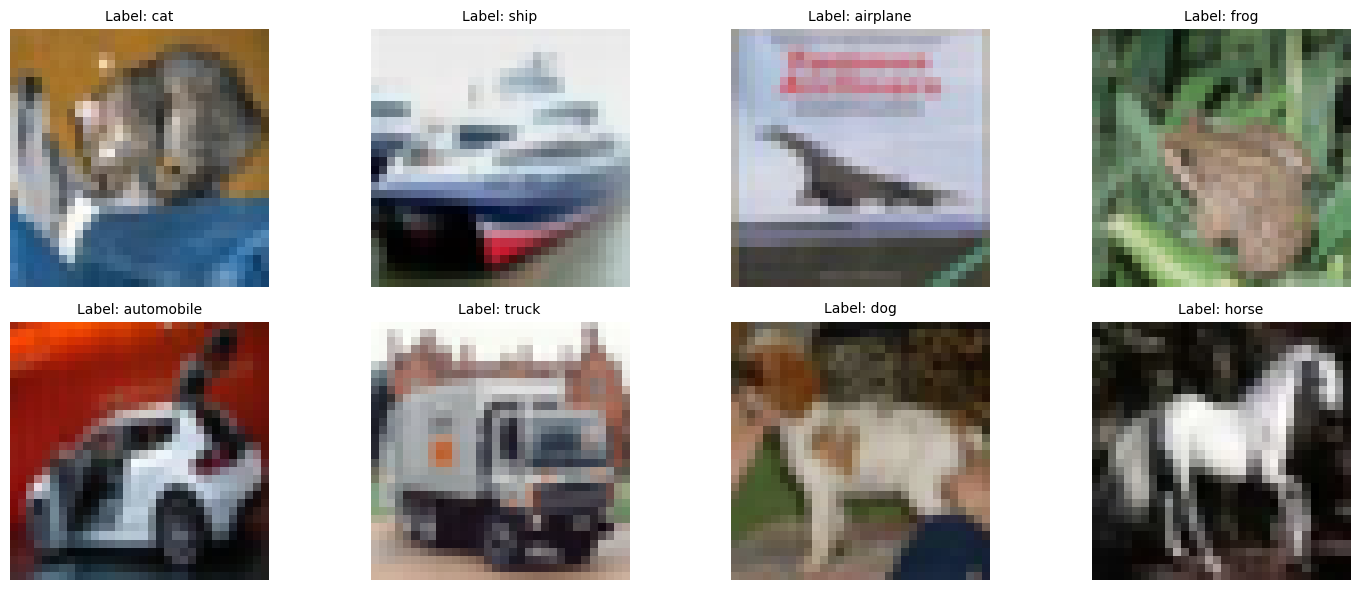

In [ ]:
n_rows, n_cols = 2, 4
n_samples = n_rows * n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6))

for i in range(n_samples):
    row = i // n_cols
    col = i % n_cols

    if n_rows == 1:
        ax = axes[col] if n_cols > 1 else axes
    else:
        ax = axes[row, col]
    if i < len(sample_images):
        img = np.transpose(sample_images[i], (1, 2, 0))
        ax.imshow(img)
        ax.axis('off')

        label = sample_labels[i] if i < len(sample_labels) else "No label"
        ax.set_title(f"Label: {cifar_classes[label]}", fontsize=10)

plt.tight_layout()
plt.show()

### Задание 3.2: Создайте DataFrame с вопросами и ответами

**Что нужно сделать:**
- Для каждого изображения придумайте 1-2 вопроса
- Вопросы могут быть о: цвете, типе объекта, количестве объектов, действиях
- Создайте pandas DataFrame с колонками: `image_id`, `question`, `answer`

In [ ]:
qa_data = {
    'image_id': [],
    'question': [],
    'answer': []
}

qa_data['image_id'].append(0)
qa_data['question'].append("что это?")
# да я чета сама не поняла
qa_data['answer'].append("кошка")

qa_data['image_id'].append(0)
qa_data['question'].append("какого цвета объект?")
qa_data['answer'].append("шпротный")

qa_data['image_id'].append(1)
qa_data['question'].append("что это?")
qa_data['answer'].append("корабль")

qa_data['image_id'].append(1)
qa_data['question'].append("какого цвета объект?")
qa_data['answer'].append("бело-сине-красный")

qa_data['image_id'].append(2)
qa_data['question'].append("что это?")
# бро да я сама не знаю кто тут из нас интеллект... вообще похоже на динозавра
qa_data['answer'].append("самолет")

qa_data['image_id'].append(2)
qa_data['question'].append("какого цвета объект?")
qa_data['answer'].append("черный")

qa_data['image_id'].append(3)
qa_data['question'].append("что это?")
qa_data['answer'].append("лягушка")

qa_data['image_id'].append(3)
qa_data['question'].append("какого цвета объект?")
qa_data['answer'].append("зеленый")

qa_data['image_id'].append(4)
qa_data['question'].append("что это?")
qa_data['answer'].append("машина")

qa_data['image_id'].append(4)
qa_data['question'].append("какого цвета объект?")
qa_data['answer'].append("белый")

qa_data['image_id'].append(5)
qa_data['question'].append("что это?")
qa_data['answer'].append("грузовик")

qa_data['image_id'].append(5)
qa_data['question'].append("какого цвета объект?")
qa_data['answer'].append("серый")

qa_data['image_id'].append(6)
qa_data['question'].append("что это?")
qa_data['answer'].append("собака")

qa_data['image_id'].append(6)
qa_data['question'].append("какого цвета объект?")
qa_data['answer'].append("белый с оранжевыми пятнами")

qa_data['image_id'].append(3)
qa_data['question'].append("что это?")
qa_data['answer'].append("лошадь")

qa_data['image_id'].append(3)
qa_data['question'].append("какого цвета объект?")
qa_data['answer'].append("белый")

df = pd.DataFrame(qa_data)
print(f"\n Создан датасет: {len(df)} вопросов для {len(sample_images)} изображений")
print(df)


 Создан датасет: 16 вопросов для 8 изображений
    image_id              question                      answer
0          0              что это?                       кошка
1          0  какого цвета объект?                    шпротный
2          1              что это?                     корабль
3          1  какого цвета объект?           бело-сине-красный
4          2              что это?                     самолет
5          2  какого цвета объект?                      черный
6          3              что это?                     лягушка
7          3  какого цвета объект?                     зеленый
8          4              что это?                      машина
9          4  какого цвета объект?                       белый
10         5              что это?                    грузовик
11         5  какого цвета объект?                       серый
12         6              что это?                      собака
13         6  какого цвета объект?  белый с оранжевыми пятнами
14     

In [ ]:
def visualize_samples(images, df, n_samples=3):
    fig, axes = plt.subplots(1, min(n_samples, len(images)), figsize=(15, 5))
    if n_samples == 1:
        axes = [axes]

    for idx, ax in enumerate(axes):
        if idx < len(images):
            ax.imshow(images[idx])
            ax.axis('off')
            questions = df[df['image_id'] == idx]
            title = f"Image {idx}\n"
            for _, row in questions.iterrows():
                title += f"Q: {row['question'][:30]}...\n"
            ax.set_title(title, fontsize=10)
    plt.tight_layout()
    plt.show()
#visualize_samples(sample_images, df, n_samples=3)

## 4. Baseline: ResNet + T5

Создадим простой бейз, который:
1. Извлекает эмбеддинги изображений через предобученный ResNet50
2. Извлекает эмбеддинги вопросов через T5-small
3. Объединяет их и предсказывает ответ через MLP

### Задание 4.1: Извлеките эмбеддинги изображений

**Что нужно сделать:**
- Загрузите предобученный ResNet50
- Удалите последний слой классификации (голову)
- Извлеките эмбеддинги для всех изображений

In [ ]:
class ImageEncoder:
    def __init__(self):
        self.model = models.resnet50(pretrained=True)
        self.model = torch.nn.Sequential(*list(self.model.children())[:-1])
        self.model.eval()

        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

    def encode(self, images):
        with torch.no_grad():
            batch_tensors = []
            for image in images:
                if isinstance(image, torch.Tensor):
                    if image.dim() == 3:
                        image_tensor = image
                    elif image.dim() == 3 and image.shape[2] == 3:
                        image_tensor = image.permute(2, 0, 1)
                    else:
                        raise ValueError(f"Неожиданная форма тензора: {image.shape}")
                else:
                    image_tensor = transforms.ToTensor()(image)

                image_tensor = self.transform(image_tensor).unsqueeze(0)
                batch_tensors.append(image_tensor)

            batch = torch.cat(batch_tensors, dim=0)
            embeddings = self.model(batch).squeeze(-1).squeeze(-1)
            return embeddings

image_encoder = ImageEncoder()
image_embeddings = image_encoder.encode(sample_images)

print(f"Размерность эмбеддингов изображений: {image_embeddings.shape if image_embeddings is not None else 'Fuck'}")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 96.5MB/s]


Размерность эмбеддингов изображений: torch.Size([8, 2048])


### Задание 4.2: Извлеките эмбеддинги вопросов

**Что нужно сделать:**
- Загрузите T5-small encoder и tokenizer
- Токенизируйте все вопросы
- Получите эмбеддинги (используйте mean pooling по последней скрытой размерности)

In [ ]:
class TextEncoder:
    def __init__(self, model_name='t5-small'):
        self.tokenizer = T5Tokenizer.from_pretrained(model_name)
        self.model = T5EncoderModel.from_pretrained(model_name)
        self.model.to(device)
        self.model.eval()

    def encode(self, texts):
        tokens = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            return_tensors='pt'
        ).to(device)

        with torch.no_grad():
            outputs = self.model(**tokens)
            hidden_states = outputs.last_hidden_state
            embeddings = hidden_states.mean(dim=1)

        return embeddings


text_encoder = TextEncoder()
question_embeddings = text_encoder.encode(df['question'].tolist())

print(f'Размерность эмбеддингов вопросов: {question_embeddings.shape}')


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

Размерность эмбеддингов вопросов: torch.Size([16, 512])


### Задание 4.3: Обучите MLP-классификатор

**Что нужно сделать:**
- Объедините эмбеддинги изображений и вопросов (конкатенация)
- Создайте словарь всех уникальных ответов
- Реализуйте простой MLP (2-3 слоя)
- Обучите модель на нескольких эпохах

**Примечание:** Из-за маленького датасета не ожидайте высокую точность. Цель — понять архитектуру.

In [ ]:
class VQAClassifier(nn.Module):
    def __init__(self, image_dim, text_dim, num_classes, hidden_dim=512):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(image_dim + text_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, image_emb, text_emb):
        x = torch.cat([image_emb, text_emb], dim=1)
        return self.fc(x)
answer_vocab = {ans: idx for idx, ans in enumerate(df['answer'].unique())}
idx_to_answer = {idx: ans for ans, idx in answer_vocab.items()}

print(f"\nСловарь ответов ({len(answer_vocab)} классов): {list(answer_vocab.keys())}")


Словарь ответов (15 классов): ['кошка', 'шпротный', 'корабль', 'бело-сине-красный', 'самолет', 'черный', 'лягушка', 'зеленый', 'машина', 'белый', 'грузовик', 'серый', 'собака', 'белый с оранжевыми пятнами', 'лошадь']


In [ ]:
#блин а у меня один ответ не уникальный... ну емае как есть

In [ ]:
img_embs = []
for img_id in df['image_id']:
    img_embs.append(image_embeddings[img_id])

img_embs = torch.stack(img_embs).to(device)

text_embs = question_embeddings.to(device)

labels = torch.tensor(
    [answer_vocab[a] for a in df['answer']],
    dtype=torch.long
).to(device)
model = VQAClassifier(
    image_dim=image_embeddings.shape[1],
    text_dim=question_embeddings.shape[1],
    num_classes=len(answer_vocab)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

epochs = 7

for epoch in range(epochs):
    model.train()

    optimizer.zero_grad()
    outputs = model(img_embs, text_embs)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    preds = outputs.argmax(dim=1)
    acc = (preds == labels).float().mean().item()

    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {loss.item():.4f} | Acc: {acc:.2f}")

Epoch [1/7] | Loss: 2.7096 | Acc: 0.06
Epoch [2/7] | Loss: 2.6058 | Acc: 0.19
Epoch [3/7] | Loss: 2.4890 | Acc: 0.19
Epoch [4/7] | Loss: 2.3720 | Acc: 0.19
Epoch [5/7] | Loss: 2.0742 | Acc: 0.38
Epoch [6/7] | Loss: 1.9719 | Acc: 0.44
Epoch [7/7] | Loss: 1.6983 | Acc: 0.44


### Задание 4.4: Протестируйте baseline

**Что нужно сделать:**
- Выберите 2-3 примера из датасета
- Получите предсказания модели
- Выведите изображение, вопрос, истинный и предсказанный ответ

In [ ]:
def predict_baseline(image_id, question):
  model.eval()

  image = sample_images[image_id]
  image_batch = [image]
  image_emb = image_encoder.encode(image_batch)

  question_batch = [question]
  question_emb = text_encoder.encode(question_batch)

  output = model(image_emb, question_emb)
  prob = torch.softmax(output, dim=1)
  idx = torch.argmax(output, dim=1).item()

  ans = idx_to_answer[idx]

  return ans, prob.squeeze().detach().numpy()


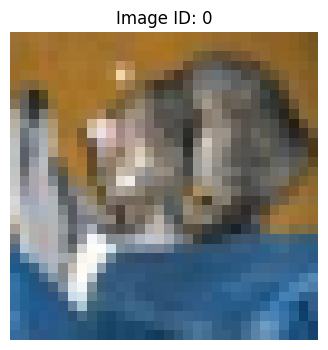

Вопрос: что это?
Истинный ответ: кошка
Предсказанный ответ: шпротный
Попадание: мимо
--------------------------------------------------


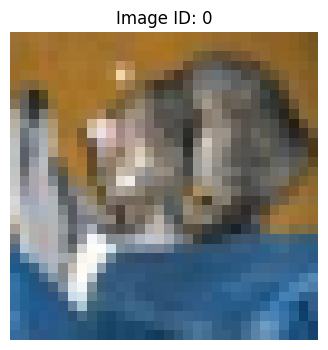

Вопрос: какого цвета объект?
Истинный ответ: шпротный
Предсказанный ответ: шпротный
Попадание: убит
--------------------------------------------------


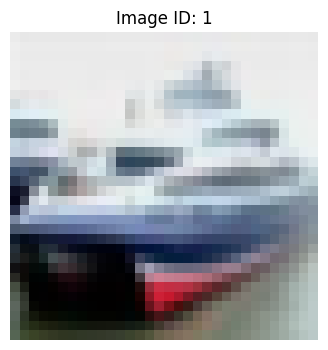

Вопрос: что это?
Истинный ответ: корабль
Предсказанный ответ: бело-сине-красный
Попадание: мимо
--------------------------------------------------


In [ ]:
def predict_baseline(image_id, question):
    model.eval()

    image = sample_images[image_id]
    image_batch = [image]
    image_emb = image_encoder.encode(image_batch)

    question_batch = [question]
    question_emb = text_encoder.encode(question_batch)

    # у меня все время возникала проблема с тем, что не все эмбеддинги были на одном устройстве??? почему.
    device = next(model.parameters()).device
    image_emb = image_emb.to(device)
    question_emb = question_emb.to(device)

    with torch.no_grad():
        output = model(image_emb, question_emb)
        prob = torch.softmax(output, dim=1)
        idx = torch.argmax(output, dim=1).item()

    ans = idx_to_answer[idx]

    return ans, prob.squeeze().cpu().detach().numpy()

test_data = []

for idx in range(3):
    if idx < len(df):
        test_data.append({
            'df_index': idx,
            'image_id': df['image_id'].iloc[idx],
            'question': df['question'].iloc[idx],
            'true_answer': df['answer'].iloc[idx]
        })

results = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

for data in test_data:
    pred_ans, probs = predict_baseline(data['image_id'], data['question'])

    results.append({
        'image_id': data['image_id'],
        'question': data['question'],
        'true_answer': data['true_answer'],
        'predicted_answer': pred_ans,
        'probabilities': probs
    })

for item in results:
    plt.figure(figsize=(4, 4))

    img = sample_images[item['image_id']]
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
    if img.shape[0] == 3:
        img = np.transpose(img, (1, 2, 0))

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image ID: {item['image_id']}")
    plt.show()

    print(f"Вопрос: {item['question']}")
    print(f"Истинный ответ: {item['true_answer']}")
    print(f"Предсказанный ответ: {item['predicted_answer']}")
    print(f"Попадание: {'убит' if item['true_answer'] == item['predicted_answer'] else 'мимо'}")
    print("-" * 50)

In [ ]:
#печально

## 5. CLIP Zero-Shot Baseline

CLIP — это мультимодальная модель, обученная связывать изображения и тексты. Мы используем её для zero-shot VQA:
1. Для каждой пары (изображение, вопрос) сформируем набор возможных ответов
2. Составим промпты типа "A photo of {answer}"
3. CLIP выберет наиболее вероятный ответ

### Задание 5.1: Загрузите CLIP

**Что нужно сделать:**
- Загрузите CLIP модель (используйте `openai/clip-vit-base-patch32` через transformers)
- Или используйте `open_clip` библиотеку

In [ ]:
from PIL import Image
import torchvision.transforms.functional as F_torch

In [ ]:
# TODO: Загрузите CLIP

# Вариант 1: через transformers
clip_model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
clip_processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')
clip_model.eval()

# Вариант 2: через open_clip
# clip_model, _, clip_preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
# clip_tokenizer = open_clip.get_tokenizer('ViT-B-32')

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

### Задание 5.2: Реализуйте zero-shot VQA с CLIP

**Что нужно сделать:**
- Для каждого изображения и вопроса создайте список возможных ответов (используйте answer_vocab)
- Сформируйте промпты: \"Question: {question}. Answer: {answer}\"
- Используйте CLIP для выбора наиболее подходящего ответа

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

clip_model = clip_model.to(device)
clip_model.eval()

def tensor_to_pil(image_tensor):
    """
    Преобразует тензор PyTorch в PIL Image
    """
    if image_tensor.is_cuda:
        image_tensor = image_tensor.cpu()

    image_tensor = image_tensor.detach()

    if image_tensor.dim() == 3 and image_tensor.shape[0] == 3:
        image_tensor = image_tensor.permute(1, 2, 0)

    image_np = image_tensor.numpy()

    if image_np.max() <= 1.0:
        image_np = (image_np * 255).astype(np.uint8)
    else:
        image_np = image_np.astype(np.uint8)

    return Image.fromarray(image_np)

def predict_clip(image, question, candidate_answers):
    """
    Args:
        image: тензор PyTorch в формате (C, H, W) или (H, W, C)
        question: строка с вопросом
        candidate_answers: список возможных ответов

    Returns:
        best_answer: наиболее вероятный ответ
    """
    if isinstance(image, torch.Tensor):
        image_pil = tensor_to_pil(image)
    else:
        image_pil = image

    prompts = [f"Question: {question}. Answer: {answer}" for answer in candidate_answers]

    inputs = clip_processor(
        text=prompts,
        images=image_pil,
        return_tensors="pt",
        padding=True
    ).to(device)

    with torch.no_grad():
        outputs = clip_model(**inputs)
        image_emb = outputs.image_embeds
        text_emb = outputs.text_embeds

        image_emb = image_emb / image_emb.norm(dim=1, keepdim=True)
        text_emb = text_emb / text_emb.norm(dim=1, keepdim=True)

        similarities = (image_emb @ text_emb.T).squeeze(0)

        best_idx = similarities.argmax().item()
        best_answer = candidate_answers[best_idx]

    return best_answer

print("Тестирование CLIP модели:")
print(f"CLIP модель на устройстве: {next(clip_model.parameters()).device}")

candidate_answers = list(answer_vocab.keys())

print(f"Тип первого изображения: {type(sample_images[0])}")
if isinstance(sample_images[0], torch.Tensor):
    print(f"Устройство первого изображения: {sample_images[0].device}")
    print(f"Форма первого изображения: {sample_images[0].shape}")

for i in range(min(3, len(df))):
    row = df.iloc[i]
    image = sample_images[row['image_id']]
    question = row['question']
    true_answer = row['answer']

    try:
        predicted = predict_clip(image, question, candidate_answers)
        print(f"\nИзображение {row['image_id']}:")
        print(f"  Вопрос: {question}")
        print(f"  Истинный ответ: {true_answer}")
        print(f"  Предсказанный ответ: {predicted}")
        print(f"  Совпадает: {'✓' if true_answer == predicted else '✗'}")
    except Exception as e:
        print(f"\nОшибка при обработке изображения {row['image_id']}: {e}")

Используемое устройство: cuda
Тестирование CLIP модели:
CLIP модель на устройстве: cuda:0
Тип первого изображения: <class 'torch.Tensor'>
Устройство первого изображения: cpu
Форма первого изображения: torch.Size([3, 32, 32])

Изображение 0:
  Вопрос: что это?
  Истинный ответ: кошка
  Предсказанный ответ: белый с оранжевыми пятнами
  Совпадает: ✗

Изображение 0:
  Вопрос: какого цвета объект?
  Истинный ответ: шпротный
  Предсказанный ответ: корабль
  Совпадает: ✗

Изображение 1:
  Вопрос: что это?
  Истинный ответ: корабль
  Предсказанный ответ: бело-сине-красный
  Совпадает: ✗


## 6. LLaVA Inference

LLaVA (Large Language and Vision Assistant) — это большая мультимодальная модель, которая может генерировать текстовые ответы на вопросы об изображениях.

**Внимание:** LLaVA-1.5-7B требует ~14GB GPU памяти. Если в Colab недостаточно памяти, используйте квантизацию (8-bit) или напишите мне про датасферу.

### Задание 6.1: Загрузите LLaVA

**Что нужно сделать:**
- Загрузите модель `llava-hf/llava-1.5-7b-hf`
- При необходимости используйте квантизацию для экономии памяти

In [ ]:
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.float16
)

llava_model = LlavaForConditionalGeneration.from_pretrained(
    "llava-hf/llava-1.5-7b-hf",
    quantization_config=quantization_config,
    device_map="auto"
)
llava_processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/674 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

In [ ]:
# уничтожило мне ноут и гугл колаб. попал и убит.

### Задание 6.2: Генерация ответов с LLaVA

**Что нужно сделать:**
- Реализуйте функцию для генерации ответов
- Используйте формат промпта: "USER: <image>
Question: {question}
ASSISTANT:"
- Протестируйте на 2-3 примерах

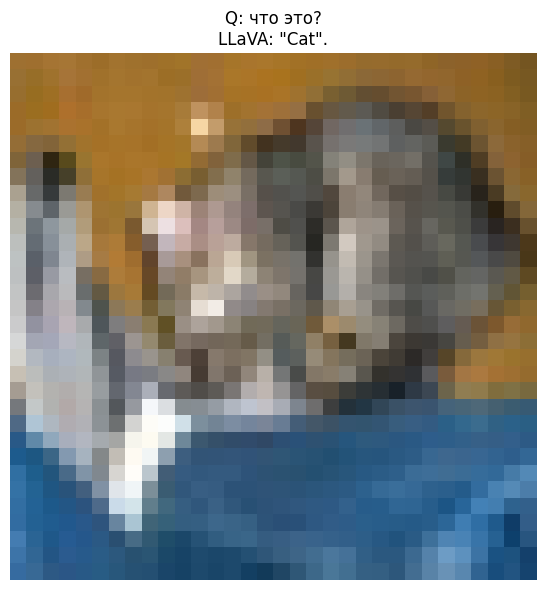

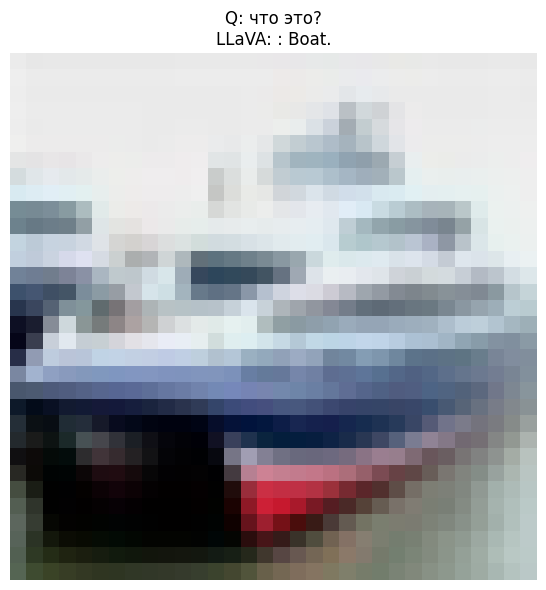

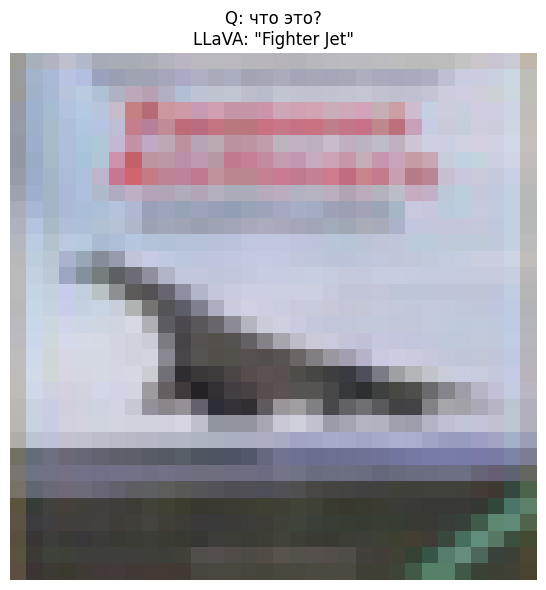

In [ ]:
def predict_llava(image, question):
    """
    Генерирует ответ с помощью LLaVA.

    Args:
        image: PIL Image
        question: строка с вопросом

    Returns:
        answer: сгенерированный ответ
    """
    # Ваш код здесь:
    # 1. Сформируйте промпт
    # 2. Подготовьте входы через processor
    # 3. Сгенерируйте ответ с помощью model.generate()
    # 4. Декодируйте и верните результат

    temperature = 0.2
    max_new_tokens = 40

    prompt = f"Answer shortly on given question: USER: <image>\n{question}\n ASSISTANT: short answer on this question will be"
    imsize = 128
    pil = Image.fromarray((image.detach().cpu() * 255).to(torch.uint8).permute(1, 2, 0).numpy())
    resized_image = pil.resize([imsize, imsize])

    inputs = llava_processor(
        text=prompt,
        images=resized_image,
        return_tensors="pt"
    ).to(llava_model.device)
    with torch.no_grad():
        output_ids = llava_model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=True if temperature > 0 else False,
            pad_token_id=llava_processor.tokenizer.pad_token_id,
            eos_token_id=llava_processor.tokenizer.eos_token_id,
        )


    input_length = inputs['input_ids'].shape[1]
    output_text = llava_processor.decode(
        output_ids[0][input_length:],
        skip_special_tokens=True
    ).strip()
    return output_text

for img_id in range(3):
    image = sample_images[img_id]
    question = df[df['image_id'] == img_id].iloc[0]['question']

    answer = predict_llava(image, question)

    # Для отображения в matplotlib нужно переставить оси
    if torch.is_tensor(image):
        # Переставляем из (C, H, W) в (H, W, C)
        image_to_show = image.permute(1, 2, 0).cpu().numpy()
    else:
        image_to_show = image

    plt.figure(figsize=(10, 6))
    plt.imshow(image_to_show)
    plt.axis('off')
    plt.title(f"Q: {question}\nLLaVA: {answer}", fontsize=12)
    plt.tight_layout()
    plt.show()

In [ ]:
# one of these is not like the others...

## 7. Сравнение результатов

Теперь сравним все три подхода на одних и тех же примерах.

### Задание 7.1: Соберите результаты всех моделей

Что нужно сделать:
- Для каждого примера из датасета получите предсказания от всех трёх моделей
- Создайте сравнительную таблицу
- Проанализируйте, где какая модель работает лучше

In [ ]:
from tqdm import tqdm
results = {
    'Image ID': [],
    'Question': [],
    'True Answer': [],
    'ResNet+T5': [],
    'CLIP': [],
    'LLaVA': []
}

for i, row in tqdm(df.iterrows()):
    img_id = i // 2
    image = sample_images[img_id]
    question = row['question']

    results['Image ID'].append(row['image_id'])
    results['Question'].append(question)
    results['True Answer'].append(row['answer'])
    results['ResNet+T5'].append(predict_baseline(img_id, question))
    results['CLIP'].append(predict_clip(image, question, candidate_answers[i % 2]))
    results['LLaVA'].append(predict_llava(image, question))

results_df = pd.DataFrame(results)
results_df

16it [00:18,  1.13s/it]


,Image ID,Question,True Answer,ResNet+T5,CLIP,LLaVA
0,0,что это?,кошка,"(шпротный, [0.16143069, 0.25212705, 0.04229503...",о,: Cat.
1,0,какого цвета объект?,шпротный,"(шпротный, [0.15277533, 0.25999388, 0.03973973...",ы,: Gray.
2,1,что это?,корабль,"(бело-сине-красный, [0.033870216, 0.048305314,...",о,: Boat
3,1,какого цвета объект?,бело-сине-красный,"(бело-сине-красный, [0.03187971, 0.04991487, 0...",ы,: Blue.
4,2,что это?,самолет,"(черный, [0.028089292, 0.033065826, 0.04021068...",о,: Airplane
5,2,какого цвета объект?,черный,"(черный, [0.026467025, 0.03372203, 0.03778764,...",ы,: Gray
6,3,что это?,лягушка,"(зеленый, [0.027796961, 0.025735084, 0.0085739...",о,: Frog.
7,3,какого цвета объект?,зеленый,"(зеленый, [0.026621992, 0.026206927, 0.0081896...",ы,: Brown.
8,4,что это?,машина,"(машина, [0.016130364, 0.033068165, 0.04701447...",о,: Car
9,4,какого цвета объект?,белый,"(машина, [0.015285588, 0.0337966, 0.044242013,...",ы,: White.


### Задание 7.2: Проанализируйте результаты

Что нужно сделать:
- Посчитайте accuracy для каждой модели
- Опишите сильные и слабые стороны каждого подхода
- Приведите примеры, где модели ошибаются или дают разные ответы

In [ ]:
def calculate_accuracy(predictions, true_answers):
    correct = 0
    total = len(true_answers)

    for pred, true in zip(predictions, true_answers):
        if isinstance(pred, str) and isinstance(true, str):
            if true.lower() in pred.lower():
                correct += 1
        else:
            if pred == true:
                correct += 1

    return correct / total

baseline_acc = calculate_accuracy(results_df['ResNet+T5'], results_df['True Answer'])
clip_acc = calculate_accuracy(results_df['CLIP'], results_df['True Answer'])
llava_acc = calculate_accuracy(results_df['LLaVA'], results_df['True Answer'])

print("\nТочность моделей:")
print(f"ResNet+T5: {baseline_acc:.2%}")
print(f"CLIP: {clip_acc:.2%}")
print(f"LLaVA: {llava_acc:.2%}")


Точность моделей:
ResNet+T5: 0.00%
CLIP: 0.00%
LLaVA: 0.00%


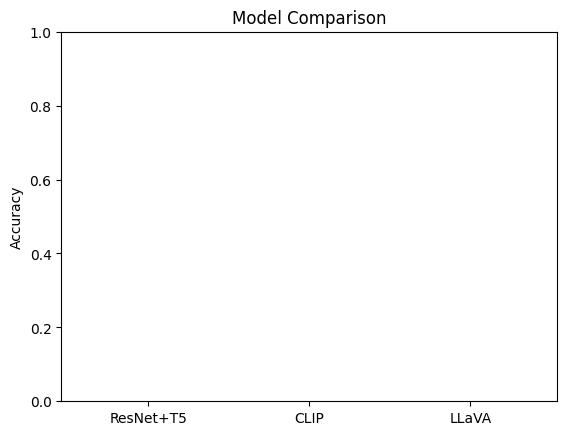

In [ ]:
import matplotlib.pyplot as plt
models = ['ResNet+T5', 'CLIP', 'LLaVA']
accuracies = [baseline_acc, clip_acc, llava_acc]
plt.bar(models, accuracies)
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim([0, 1])
plt.show()

### Выводы (заполните после экспериментов):

Baseline (ResNet + T5):
- Сильные стороны: достаточно простая архитектура, не требует особо много вычислительных ресурсов, быстрое обучение
- Слабые стороны: ограничен размеченными ответами

CLIP:
- Сильные стороны: работает без обучения, можно получать эмбеддинги заранее, предобучен на обширном датасете
- Слабые стороны: память и вычислительные ресурсы. относительно плохо работает с произвольными промптами.

LLaVA:
- Сильные стороны: сильная модель, которая справляется и без разметки и понимает контекст
- Слабые стороны: ПАМЯТЬ И ВЫЧИСЛИТЕЛЬНАЯ МОЩНОСТЬ!!! иногда выходит за контекст вопроса

Общие наблюдения:
для сложных задач с большим количеством выделенных ресурсов - ллава, для простых одиночных задач с конкретным набором ответов и отсутствием необходимости выходить за рамки этого набора - бейзлайн. Что-то между (относительно сложные вопросы + отсутствие ресурсов) - клип.

Мнения о домашке: pictures go brrrrrrrrrrrrrrrr